# Introduction:

If you're like me, you love quality Asian food, more specifically Chinese dumplings. So, if you are traveling to a new city you are eager to find the best places to chow down. The problem that I will be solving for, is leveraging Chinese restaurant densities within neighborhoods of Toronto to determine where someone from out of town should go in order to fill their bellies on yummy food.

# Data Solution Proposal:

I will use the FourSquare API to collect data about locations of Chinese restaurants in Toronto, ON neighborhoods. Given that Toronto is a burgeoning food city in the southern United States, I am confident that we will be able to glean the best areas within the city to fulfill one's craving for Chinese food.

In [1]:
!pip install folium
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
#!pip install geocoder #uncomment if the module isn't installed
import os
#!pip install folium #uncomment if the module isn't installed
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

     |████████████████████████████████| 93 kB 3.4 MB/s  eta 0:00:01
Libraries imported.


# Cleaning Toronto Location Data

In [2]:
source = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(source, 'lxml')

table = soup.find("table")
table_rows = table.tbody.find_all("tr")

res = []
for tr in table_rows:
    td = tr.find_all("td")
    row = [tr.text for tr in td]
    
    # Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
    if row != [] and row[1] != "Not assigned\n":
        # If a cell has a borough but a "Not assigned" neighborhood, then the neighborhood will be the same as the borough.
        if "Not assigned" in row[2]: 
            row[2] = row[1]
        res.append(row)

# Dataframe with 3 columns
df = pd.DataFrame(res, columns = ["PostalCode", "Borough", "Neighborhood"])

df["PostalCode"] = df["PostalCode"].str.replace("\n","")
df["Borough"] = df["Borough"].str.replace("\n","")
df["Neighborhood"] = df["Neighborhood"].str.replace("\n","")

df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [3]:
df_lat_lon = pd.read_csv('https://cocl.us/Geospatial_data')
df_lat_lon.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [4]:
df_toronto = pd.merge(df, df_lat_lon, how='left', left_on = 'PostalCode', right_on = 'Postal Code')
# remove the "Postal Code" column
df_toronto.drop("Postal Code", axis=1, inplace=True)
df_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [5]:
# How many  neighborhood are there in Toronto City?
print("Total number of Neighborhood is {}".format(df_toronto.shape[0]))

Total number of Neighborhood is 103


# Count of Neighborhoods by Toronto Borough

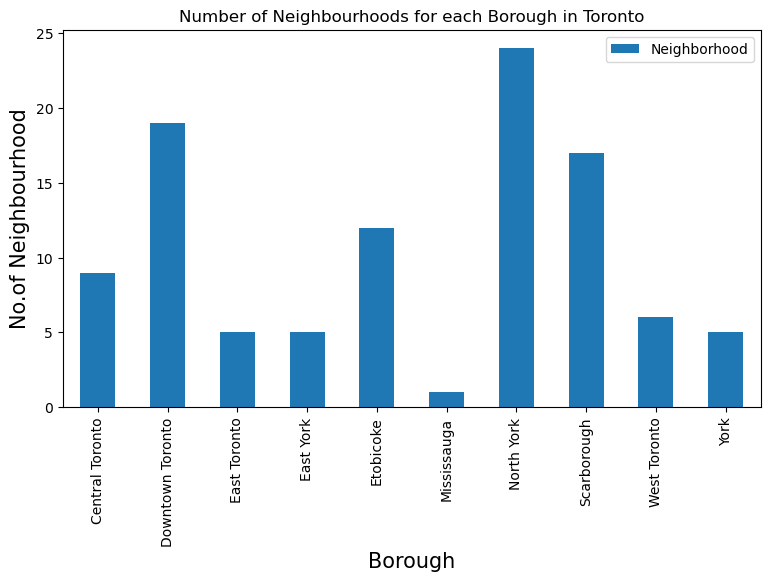

In [6]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighbourhoods for each Borough in Toronto')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighbourhood', fontsize=15)
#giving a bar plot
df_toronto.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [7]:
print("Maximum number of Neighborhoods in a single borough is {}".format(max(df_toronto.groupby('Borough')['Neighborhood'].count())))

Maximum number of Neighborhoods in a single borough is 24


# FourSquare API Setup

In [8]:
CLIENT_ID = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx' # your Foursquare ID
CLIENT_SECRET = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx' # your Foursquare Secret
VERSION = '20200518' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)

Your credentails:
CLIENT_ID: DC2Y3PMQFJNCKWYODIVEHWEW0PM42KYABAUWWQTLD4JPDKGT


# Gathering FourSquare Chinese Restaurant Data in Toronto

In [9]:
def get_venues(lat,lng):
    
    #set variables
    radius=2000
    LIMIT=50
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [10]:
def get_venue_details(venue_id):
        
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [11]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinrest_toronto = pd.DataFrame(columns=column_names)
count=1
for row in df_toronto.values.tolist():
    PostalCode, Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    dumpling_resturants = venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(df_toronto),')','Chinese Restaurant in '+Neighborhood+', '+Borough+':'+str(len(dumpling_resturants)))
    for restaurant_detail in dumpling_resturants.values.tolist():
        id, name , category = restaurant_detail
        chinrest_toronto = chinrest_toronto.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 103 ) Chinese Restaurant in Parkwoods, North York:2
( 2 / 103 ) Chinese Restaurant in Victoria Village, North York:1
( 3 / 103 ) Chinese Restaurant in Regent Park, Harbourfront, Downtown Toronto:0
( 4 / 103 ) Chinese Restaurant in Lawrence Manor, Lawrence Heights, North York:0
( 5 / 103 ) Chinese Restaurant in Queen's Park, Ontario Provincial Government, Downtown Toronto:0
( 6 / 103 ) Chinese Restaurant in Islington Avenue, Humber Valley Village, Etobicoke:0
( 7 / 103 ) Chinese Restaurant in Malvern, Rouge, Scarborough:0
( 8 / 103 ) Chinese Restaurant in Don Mills, North York:0
( 9 / 103 ) Chinese Restaurant in Parkview Hill, Woodbine Gardens, East York:0
( 10 / 103 ) Chinese Restaurant in Garden District, Ryerson, Downtown Toronto:0
( 11 / 103 ) Chinese Restaurant in Glencairn, North York:0
( 12 / 103 ) Chinese Restaurant in West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale, Etobicoke:0
( 13 / 103 ) Chinese Restaurant in Rouge Hill, Port Union, Highland Cree

In [12]:
# lets see total number of indian restaurants in Toronto
print("Total number of Chinese Restaurants in Toronto City is {}".format(chinrest_toronto.shape[0]))

Total number of Chinese Restaurants in Toronto City is 60


In [13]:
chinrest_toronto.head()

,Borough,Neighborhood,ID,Name
0,North York,Parkwoods,5b6a321d340a58002cc0d9db,Omni Palace Noodle House
1,North York,Parkwoods,4c9f77980e9bb1f7659bf05f,The Bean Sprout
2,North York,Victoria Village,4c9f77980e9bb1f7659bf05f,The Bean Sprout
3,York,Humewood-Cedarvale,4ce588455fce5481cd1e5caa,Cho Cho Cho
4,Etobicoke,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",4bfefc3b68c7a593dc004044,Golden Wok Chinese Restaurant


# Chinese Restaurants by Borough in Toronto

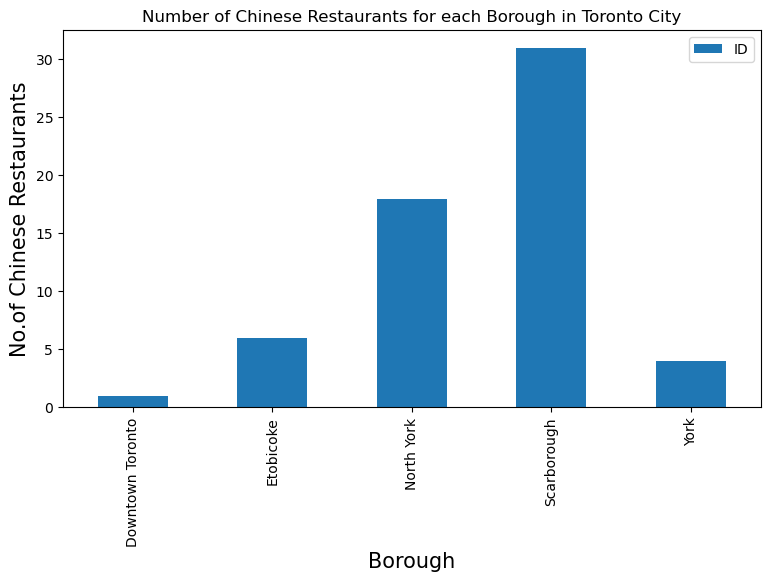

In [14]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Restaurants for each Borough in Toronto City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Restaurants', fontsize=15)
#giving a bar plot
chinrest_toronto.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [15]:
print("Maximum number of Chinese restaurants in a single Borough is {}".format(max(chinrest_toronto.groupby('Borough')['ID'].count())))

Maximum number of Chinese restaurants in a single Borough is 31


# Chinese Restaurants by Neigbhorhood in Toronto

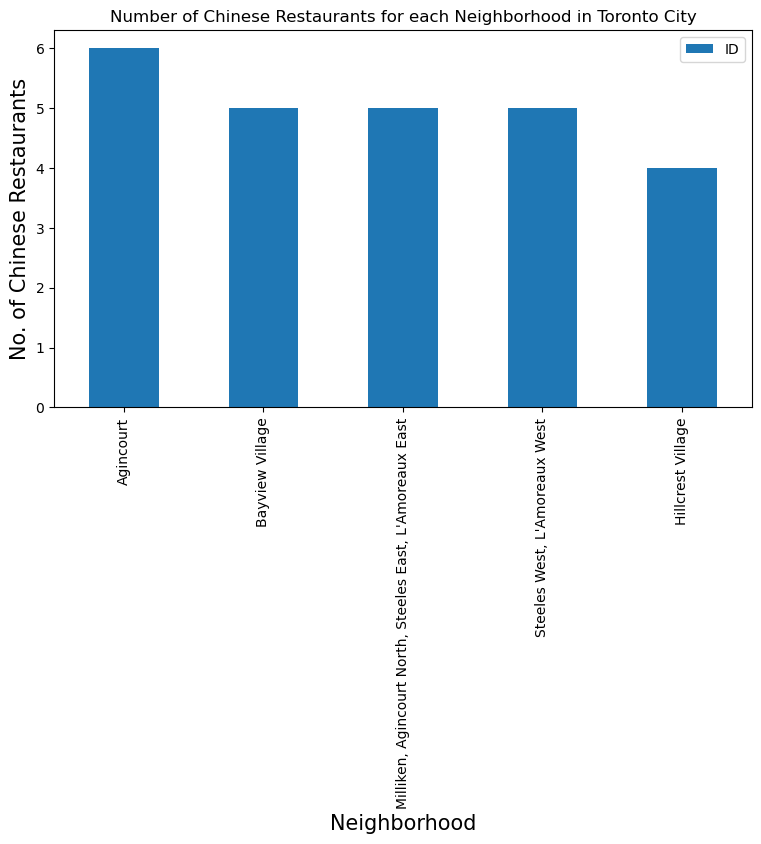

In [16]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Restaurants for each Neighborhood in Toronto City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No. of Chinese Restaurants', fontsize=15)
#giving a bar plot
chinrest_toronto.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [17]:
print("Maximum number of Chinese restaurants in a single Neighborhood is {}".format(max(chinrest_toronto.groupby('Neighborhood')['ID'].count())))

Maximum number of Chinese restaurants in a single Neighborhood is 6


In [19]:
# prepare neighborhood list that contains chinese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats = pd.DataFrame(columns = column_names)
count=1


for row in chinrest_toronto.values.tolist():
    Borough, Neighborhood, ID, Name = row
    try:
        venue_details = get_venue_details(ID)
        print(venue_details)
        id1, name, likes, rating, tips = venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id1, name, likes, rating, tips = [0]*5
    print('(',count,'/',len(chinrest_toronto),')','processed')
    chinese_rest_stats = chinese_rest_stats.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id1,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                      Name  Likes  Rating  Tips
0  5b6a321d340a58002cc0d9db  Omni Palace Noodle House      7     7.2     3
( 1 / 60 ) processed
                         ID             Name  Likes  Rating  Tips
0  4c9f77980e9bb1f7659bf05f  The Bean Sprout      4     7.0     5
( 2 / 60 ) processed
                         ID             Name  Likes  Rating  Tips
0  4c9f77980e9bb1f7659bf05f  The Bean Sprout      4     7.0     5
( 3 / 60 ) processed
                         ID         Name  Likes  Rating  Tips
0  4ce588455fce5481cd1e5caa  Cho Cho Cho      3     7.4     5
( 4 / 60 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4bfefc3b68c7a593dc004044
( 5 / 60 ) processed
                         ID         Name  Likes  Rating  Tips
0  4ce588455fce5481cd1e5caa  Cho Cho Cho      3     7.4     5
( 6 / 60 ) processed
                         ID          Name  Likes  Rating  Tips
0  54a6ea76498ebc906c8c3652  Ha

KeyError: 'venue'

In [20]:
# print first five elements of chinese_rest_stats
print(chinese_rest_stats.columns)

Index(['Borough', 'Neighborhood', 'ID', 'Name', 'Likes', 'Rating', 'Tips'], dtype='object')


# Rating Restaurants

In [21]:
toronto_neighborhood_stat = chinese_rest_stats.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
toronto_neighborhood_stat.columns = ['Neighborhood','Average Rating']
toronto_neighborhood_stat.sort_values(by = 'Average Rating', ascending = False, inplace = True)

toronto_neighborhood_stat.head()

,Neighborhood,Average Rating
16,"Milliken, Agincourt North, Steeles East, L'Amo...",8.4
11,"Harbourfront East, Union Station, Toronto Islands",7.7
6,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",7.5
17,"North Park, Maple Leaf Park, Upwood Park",7.5
13,Humewood-Cedarvale,7.4


In [22]:
# print the neighborhood with maximum rating
print("Neighborhood : {}, Average Rating : {}".format(toronto_neighborhood_stat.iloc[0][0] ,toronto_neighborhood_stat.iloc[0][1]))

Neighborhood : Milliken, Agincourt North, Steeles East, L'Amoreaux East, Average Rating : 8.4


In [23]:
toronto_neighborhood_stat = pd.merge(toronto_neighborhood_stat,df_toronto, on='Neighborhood')
toronto_neighborhood_stat.reset_index()
toronto_neighborhood_stat

,Neighborhood,Average Rating,PostalCode,Borough,Latitude,Longitude
0,"Milliken, Agincourt North, Steeles East, L'Amo...",8.400000,M1V,Scarborough,43.815252,-79.284577
1,"Harbourfront East, Union Station, Toronto Islands",7.700000,M5J,Downtown Toronto,43.640816,-79.381752
2,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",7.500000,M6M,York,43.691116,-79.476013
3,"North Park, Maple Leaf Park, Upwood Park",7.500000,M6L,North York,43.713756,-79.490074
4,Humewood-Cedarvale,7.400000,M6C,York,43.693781,-79.428191
5,Caledonia-Fairbanks,7.400000,M6E,York,43.689026,-79.453512
6,"Willowdale, Willowdale West",7.400000,M2R,North York,43.782736,-79.442259
7,Hillcrest Village,7.350000,M2H,North York,43.803762,-79.363452
8,"Clarks Corners, Tam O'Shanter, Sullivan",7.300000,M1T,Scarborough,43.781638,-79.304302
9,"Golden Mile, Clairlea, Oakridge",7.300000,M1L,Scarborough,43.711112,-79.284577


In [25]:
toronto_map = folium.Map(location = [43.653963, -79.387207 ], zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

for lat, lng, in toronto_neighborhood_stat[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
    
toronto_map

In [26]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location = [43.653963, -79.387207 ], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_neighborhood_stat['Latitude'], toronto_neighborhood_stat['Longitude'], toronto_neighborhood_stat['Borough'], toronto_neighborhood_stat['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

# Conclusion

Milliken, Agincourt North, Steeles East, L'Amoreaux East in the Scarborough borough has the highest average rating for Chinese restaurants in the city of Toronto at: 8.4 according to FourSquare API data. However, the neighborhood with the most Chinese restaurants was Agincourt which is also located in the Scarborough borough. It makes sense that the neighborhood with the highest average rating for restaurant would be in close proximity to the neighborhood with the highest density of Chinese restaurants, considering that Toronto's "Chinatown" is located in the northeast portion of the city. All that said, it sounds like there are bound to be some great dumplings in the Northeastern Scarborough district if you ever find yourself visiting Toronto.

*It is worth noting that FourSquare data is crowdsourced and based off of user experience. So, please keep in mind that there can be inherent biases when using such a data collection method.